In [1]:
!pip install torchattacks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 941.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.9/143.9 kB 1.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.w

In [2]:
import torchattacks
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# MNIST Test dataset and dataloader declaration
batch_size = 1;

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ])),
        batch_size= batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ])),
        batch_size=batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 36005171.18it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1198200.69it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9627172.82it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 756063.37it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [4]:
classes = [
    '0',
    '1',
    '2',
    '3',
    '4',
    '5',
    '6',
    '7',
    '8',
    '9'
]


# Iterate over the data loader to get the shape of the data
for images, labels in train_loader:
    print("Shape of images tensor:", images.shape)
    print("Shape of labels tensor:", labels.shape)
    break  # Exit the loop after the first batch

Shape of images tensor: torch.Size([1, 1, 28, 28])
Shape of labels tensor: torch.Size([1])


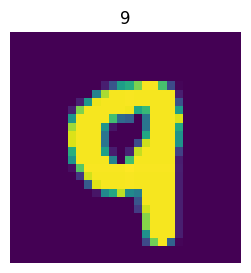

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Function to convert a tensor to a numpy image
def tensor_to_image(tensor):
    # Convert tensor to numpy array
    image = tensor.numpy()
    # Rescale the pixel values to be between 0 and 1
    image = image / 2 + 0.5
    # Reorder dimensions to (height, width, channels)
    image = np.transpose(image, (1, 2, 0))
    return image

# Function to display a single image
def show_image(image, label, classes):
    # Convert tensor to numpy array
    image = tensor_to_image(image)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(4, 3))

    # Plot the image
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(classes[label.item()])

    # Show the plot
    plt.show()

# Get a batch of images and labels
images, labels = next(iter(train_loader))

# Assuming you want to display the first image in the batch
image_to_display = images[0]
label_to_display = labels[0]

# Display the image
show_image(image_to_display, label_to_display, classes)

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # Change input channels to 1
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Adjust input features for 28x28 input size
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Adjust for the flattened feature size
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = SimpleCNN().to(device)


import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):  # loop over the dataset multiple times
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:  # get the inputs; images.to(device), labels.to(device) is a list of [images, labels]
        images, labels = images.to(device), labels.to(device)  # Move data to GPU

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in test_loader:  # Change from train_loader to test_loader for validation
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = correct_val / total_val

    # Print training and validation statistics
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch 1/5, Loss: 0.1191, Train Accuracy: 0.9648, Val Accuracy: 0.9785
Epoch 2/5, Loss: 0.0722, Train Accuracy: 0.9806, Val Accuracy: 0.9847
Epoch 3/5, Loss: 0.0592, Train Accuracy: 0.9845, Val Accuracy: 0.9851
Epoch 4/5, Loss: 0.0552, Train Accuracy: 0.9860, Val Accuracy: 0.9850
Epoch 5/5, Loss: 0.0507, Train Accuracy: 0.9872, Val Accuracy: 0.9824


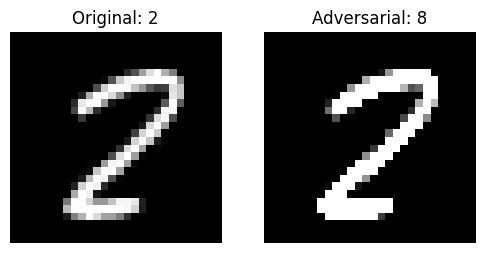

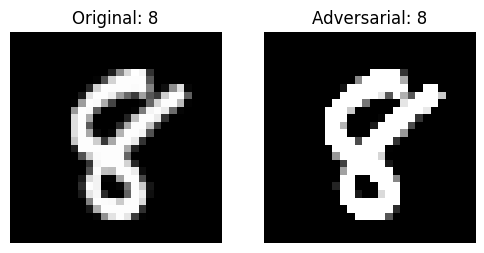

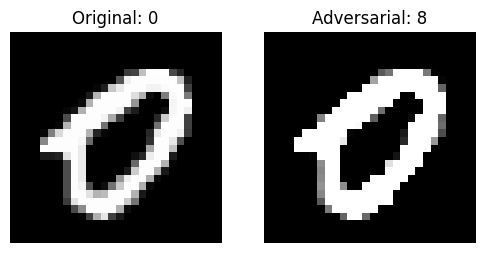

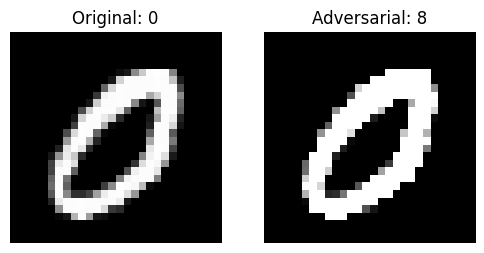

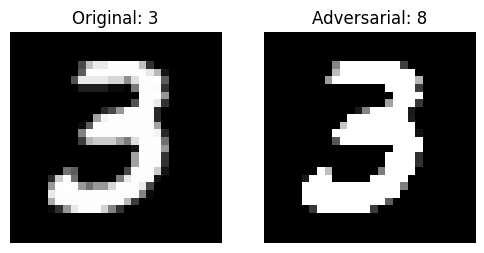

Success Rate: 0.9200


In [9]:
# Define the FFGSM attack
attack_ffgsm = torchattacks.FFGSM(model)

# Function to convert a tensor to a numpy image (adjusted for grayscale images)
def tensor_to_image(tensor):
    image = tensor.cpu().numpy()
    image = image * 0.3081 + 0.1307  # De-normalize the image
    if image.shape[0] == 1:
        image = image.squeeze(0)
    return image

# Function to display original and adversarial images side by side
def show_images_side_by_side(original_image, adversarial_image, original_label, adversarial_label, classes):
    original_image = tensor_to_image(original_image)
    adversarial_image = tensor_to_image(adversarial_image)
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))

    # Original image
    axs[0].imshow(original_image, cmap='gray')
    axs[0].axis('off')
    axs[0].set_title(f"Original: {classes[original_label]}")

    # Adversarial image
    axs[1].imshow(adversarial_image, cmap='gray')
    axs[1].axis('off')
    axs[1].set_title(f"Adversarial: {classes[adversarial_label]}")

    plt.show()

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = 100  # Number of samples to test

for _ in range(total_samples):
    index_ffgsm = np.random.randint(0, len(test_loader.dataset))
    original_image_ffgsm, original_label_ffgsm = test_loader.dataset[index_ffgsm]

    original_label_tensor_ffgsm = torch.tensor(original_label_ffgsm)
    original_image_ffgsm = original_image_ffgsm.unsqueeze(0).to(device)
    original_label_tensor_ffgsm = original_label_tensor_ffgsm.unsqueeze(0).to(device)

    adv_images_ffgsm = attack_ffgsm(original_image_ffgsm, original_label_tensor_ffgsm)

    original_prediction_ffgsm = torch.argmax(model(original_image_ffgsm))
    adversarial_prediction_ffgsm = torch.argmax(model(adv_images_ffgsm))

    if original_prediction_ffgsm != adversarial_prediction_ffgsm:
        successful_attacks += 1

    if _ < 5:
        show_images_side_by_side(
            original_image_ffgsm.cpu().squeeze(),
            adv_images_ffgsm.cpu().squeeze(),
            original_prediction_ffgsm.item(),
            adversarial_prediction_ffgsm.item(),
            classes
        )

# Calculate the success rate
success_rate = successful_attacks / total_samples
print(f"Success Rate: {success_rate:.4f}")

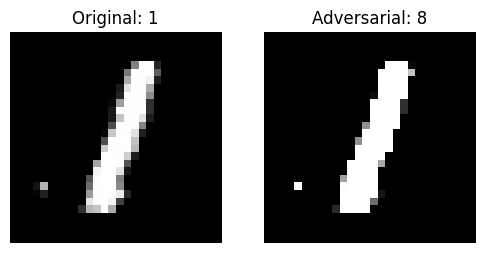

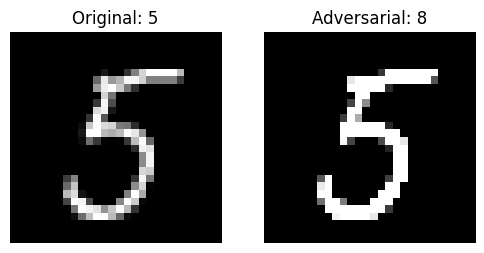

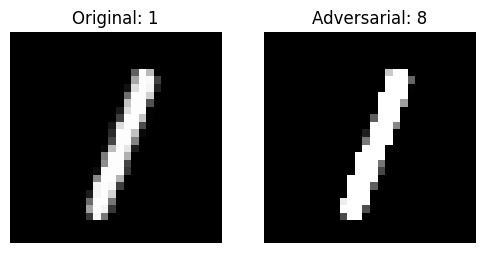

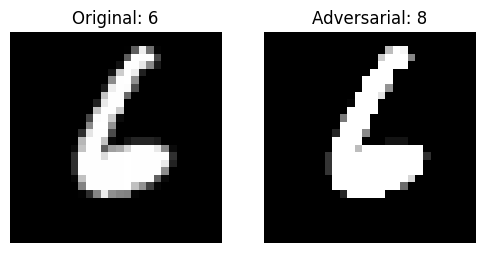

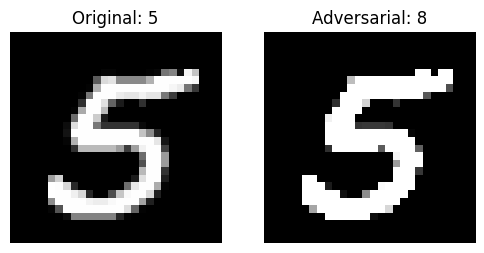

Success Rate: 0.9400


In [10]:
# Define the RFGSM attack
attack_rfgsm = torchattacks.RFGSM(model)

# Function to convert a tensor to a numpy image (adjusted for grayscale images)
def tensor_to_image(tensor):
    image = tensor.cpu().numpy()
    image = image * 0.3081 + 0.1307  # De-normalize the image
    if image.shape[0] == 1:
        image = image.squeeze(0)
    return image

# Function to display original and adversarial images side by side
def show_images_side_by_side(original_image, adversarial_image, original_label, adversarial_label, classes):
    original_image = tensor_to_image(original_image)
    adversarial_image = tensor_to_image(adversarial_image)
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))

    # Original image
    axs[0].imshow(original_image, cmap='gray')
    axs[0].axis('off')
    axs[0].set_title(f"Original: {classes[original_label]}")

    # Adversarial image
    axs[1].imshow(adversarial_image, cmap='gray')
    axs[1].axis('off')
    axs[1].set_title(f"Adversarial: {classes[adversarial_label]}")

    plt.show()

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = 100  # Number of samples to test

for _ in range(total_samples):
    index_rfgsm = np.random.randint(0, len(test_loader.dataset))
    original_image_rfgsm, original_label_rfgsm = test_loader.dataset[index_rfgsm]

    original_label_tensor_rfgsm = torch.tensor(original_label_rfgsm)
    original_image_rfgsm = original_image_rfgsm.unsqueeze(0).to(device)
    original_label_tensor_rfgsm = original_label_tensor_rfgsm.unsqueeze(0).to(device)

    adv_images_rfgsm = attack_rfgsm(original_image_rfgsm, original_label_tensor_rfgsm)

    original_prediction_rfgsm = torch.argmax(model(original_image_rfgsm))
    adversarial_prediction_rfgsm = torch.argmax(model(adv_images_rfgsm))

    if original_prediction_rfgsm != adversarial_prediction_rfgsm:
        successful_attacks += 1

    if _ < 5:
        show_images_side_by_side(
            original_image_rfgsm.cpu().squeeze(),
            adv_images_rfgsm.cpu().squeeze(),
            original_prediction_rfgsm.item(),
            adversarial_prediction_rfgsm.item(),
            classes
        )

# Calculate the success rate
success_rate = successful_attacks / total_samples
print(f"Success Rate: {success_rate:.4f}")


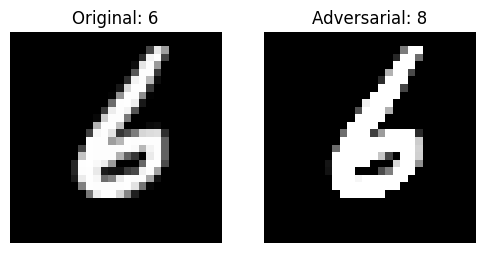

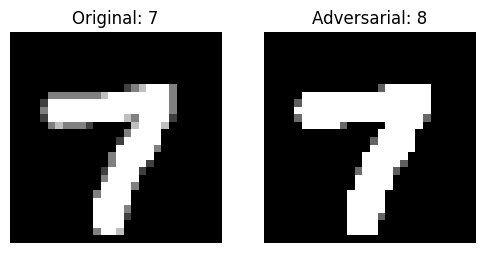

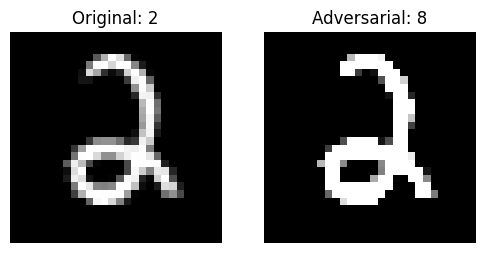

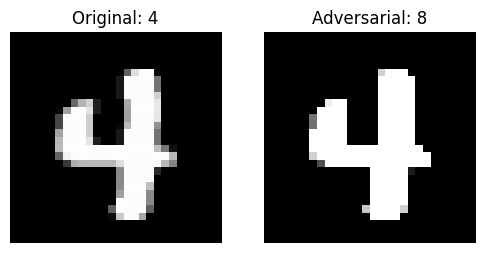

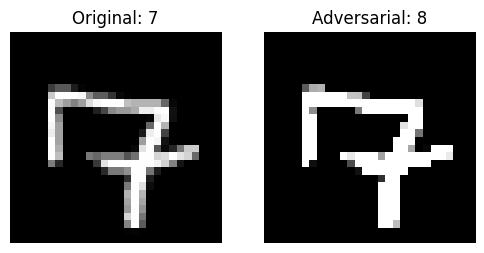

Success Rate: 0.9000


In [11]:
# Define the PGD attack
attack_pgd = torchattacks.PGD(model)

# Function to convert a tensor to a numpy image (adjusted for grayscale images)
def tensor_to_image(tensor):
    image = tensor.cpu().numpy()
    image = image * 0.3081 + 0.1307  # De-normalize the image
    if image.shape[0] == 1:
        image = image.squeeze(0)
    return image

# Function to display original and adversarial images side by side
def show_images_side_by_side(original_image, adversarial_image, original_label, adversarial_label, classes):
    original_image = tensor_to_image(original_image)
    adversarial_image = tensor_to_image(adversarial_image)
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))

    # Original image
    axs[0].imshow(original_image, cmap='gray')
    axs[0].axis('off')
    axs[0].set_title(f"Original: {classes[original_label]}")

    # Adversarial image
    axs[1].imshow(adversarial_image, cmap='gray')
    axs[1].axis('off')
    axs[1].set_title(f"Adversarial: {classes[adversarial_label]}")

    plt.show()

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = 100  # Number of samples to test

for _ in range(total_samples):
    index_pgd = np.random.randint(0, len(test_loader.dataset))
    original_image_pgd, original_label_pgd = test_loader.dataset[index_pgd]

    original_label_tensor_pgd = torch.tensor(original_label_pgd)
    original_image_pgd = original_image_pgd.unsqueeze(0).to(device)
    original_label_tensor_pgd = original_label_tensor_pgd.unsqueeze(0).to(device)

    adv_images_pgd = attack_pgd(original_image_pgd, original_label_tensor_pgd)

    original_prediction_pgd = torch.argmax(model(original_image_pgd))
    adversarial_prediction_pgd = torch.argmax(model(adv_images_pgd))

    if original_prediction_pgd != adversarial_prediction_pgd:
        successful_attacks += 1

    if _ < 5:
        show_images_side_by_side(
            original_image_pgd.cpu().squeeze(),
            adv_images_pgd.cpu().squeeze(),
            original_prediction_pgd.item(),
            adversarial_prediction_pgd.item(),
            classes
        )

# Calculate the success rate
success_rate = successful_attacks / total_samples
print(f"Success Rate: {success_rate:.4f}")


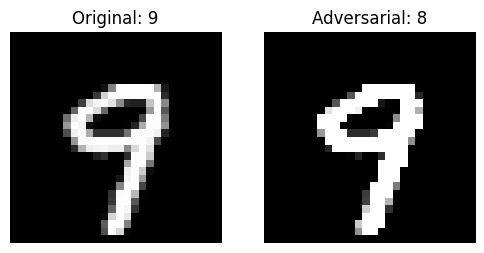

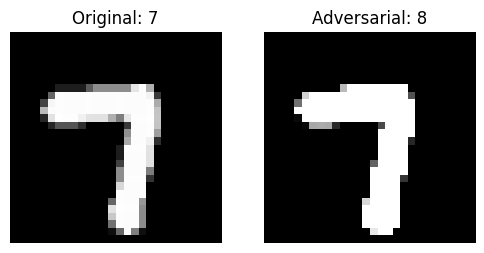

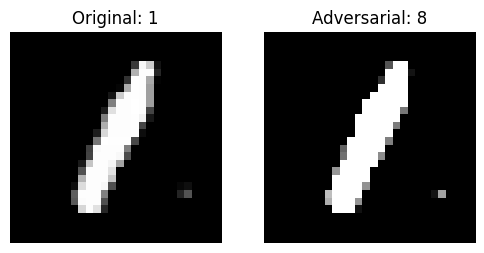

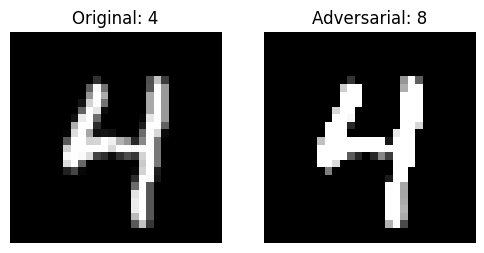

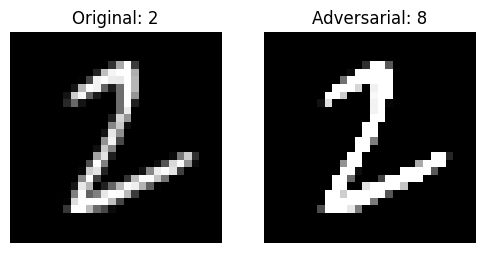

Success Rate: 0.9000


In [12]:
# Define the EOTPGD attack
attack_eotpgd = torchattacks.EOTPGD(model)

# Function to convert a tensor to a numpy image (adjusted for grayscale images)
def tensor_to_image(tensor):
    image = tensor.cpu().numpy()
    image = image * 0.3081 + 0.1307  # De-normalize the image
    if image.shape[0] == 1:
        image = image.squeeze(0)
    return image

# Function to display original and adversarial images side by side
def show_images_side_by_side(original_image, adversarial_image, original_label, adversarial_label, classes):
    original_image = tensor_to_image(original_image)
    adversarial_image = tensor_to_image(adversarial_image)
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))

    # Original image
    axs[0].imshow(original_image, cmap='gray')
    axs[0].axis('off')
    axs[0].set_title(f"Original: {classes[original_label]}")

    # Adversarial image
    axs[1].imshow(adversarial_image, cmap='gray')
    axs[1].axis('off')
    axs[1].set_title(f"Adversarial: {classes[adversarial_label]}")

    plt.show()

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = 100  # Number of samples to test

for _ in range(total_samples):
    index_eotpgd = np.random.randint(0, len(test_loader.dataset))
    original_image_eotpgd, original_label_eotpgd = test_loader.dataset[index_eotpgd]

    original_label_tensor_eotpgd = torch.tensor(original_label_eotpgd)
    original_image_eotpgd = original_image_eotpgd.unsqueeze(0).to(device)
    original_label_tensor_eotpgd = original_label_tensor_eotpgd.unsqueeze(0).to(device)

    adv_images_eotpgd = attack_eotpgd(original_image_eotpgd, original_label_tensor_eotpgd)

    original_prediction_eotpgd = torch.argmax(model(original_image_eotpgd))
    adversarial_prediction_eotpgd = torch.argmax(model(adv_images_eotpgd))

    if original_prediction_eotpgd != adversarial_prediction_eotpgd:
        successful_attacks += 1

    if _ < 5:
        show_images_side_by_side(
            original_image_eotpgd.cpu().squeeze(),
            adv_images_eotpgd.cpu().squeeze(),
            original_prediction_eotpgd.item(),
            adversarial_prediction_eotpgd.item(),
            classes
        )

# Calculate the success rate
success_rate = successful_attacks / total_samples
print(f"Success Rate: {success_rate:.4f}")



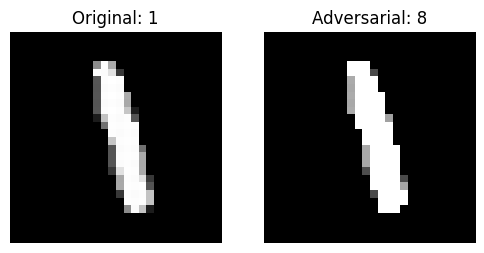

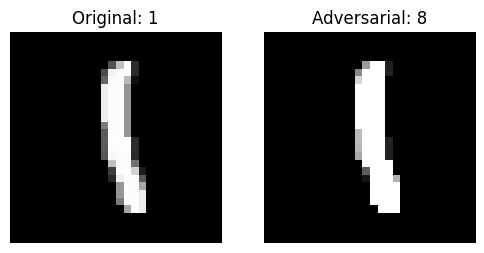

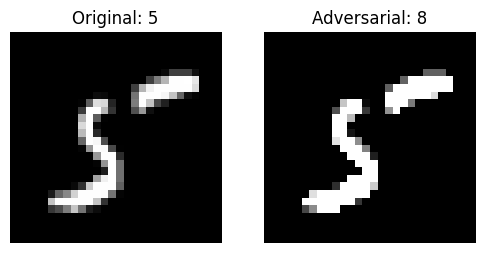

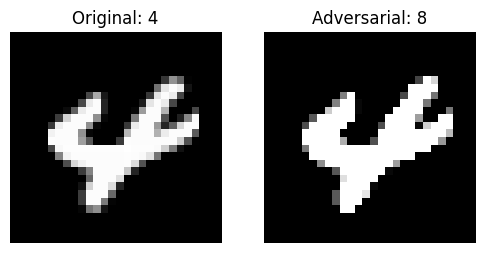

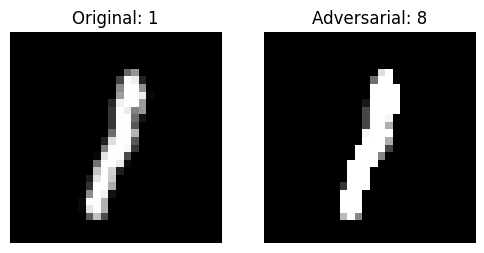

Success Rate: 0.8700


In [13]:
# Define the CW attack
attack_cw = torchattacks.CW(model)

# Function to convert a tensor to a numpy image (adjusted for grayscale images)
def tensor_to_image(tensor):
    image = tensor.cpu().numpy()
    image = image * 0.3081 + 0.1307  # De-normalize the image
    if image.shape[0] == 1:
        image = image.squeeze(0)
    return image

# Function to display original and adversarial images side by side
def show_images_side_by_side(original_image, adversarial_image, original_label, adversarial_label, classes):
    original_image = tensor_to_image(original_image)
    adversarial_image = tensor_to_image(adversarial_image)
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))

    # Original image
    axs[0].imshow(original_image, cmap='gray')
    axs[0].axis('off')
    axs[0].set_title(f"Original: {classes[original_label]}")

    # Adversarial image
    axs[1].imshow(adversarial_image, cmap='gray')
    axs[1].axis('off')
    axs[1].set_title(f"Adversarial: {classes[adversarial_label]}")

    plt.show()

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = 100  # Number of samples to test

for _ in range(total_samples):
    index_cw = np.random.randint(0, len(test_loader.dataset))
    original_image_cw, original_label_cw = test_loader.dataset[index_cw]

    original_label_tensor_cw = torch.tensor(original_label_cw)
    original_image_cw = original_image_cw.unsqueeze(0).to(device)
    original_label_tensor_cw = original_label_tensor_cw.unsqueeze(0).to(device)

    adv_images_cw = attack_cw(original_image_cw, original_label_tensor_cw)

    original_prediction_cw = torch.argmax(model(original_image_cw))
    adversarial_prediction_cw = torch.argmax(model(adv_images_cw))

    if original_prediction_cw != adversarial_prediction_cw:
        successful_attacks += 1

    if _ < 5:
        show_images_side_by_side(
            original_image_cw.cpu().squeeze(),
            adv_images_cw.cpu().squeeze(),
            original_prediction_cw.item(),
            adversarial_prediction_cw.item(),
            classes
        )

# Calculate the success rate
success_rate = successful_attacks / total_samples
print(f"Success Rate: {success_rate:.4f}")


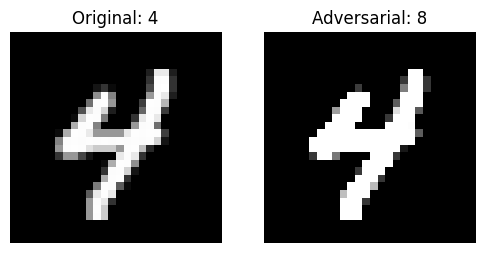

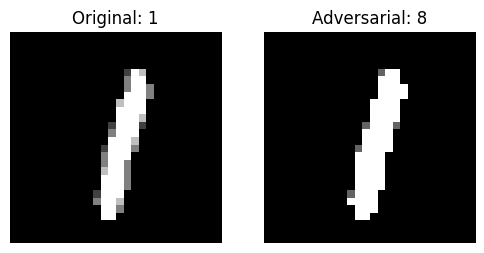

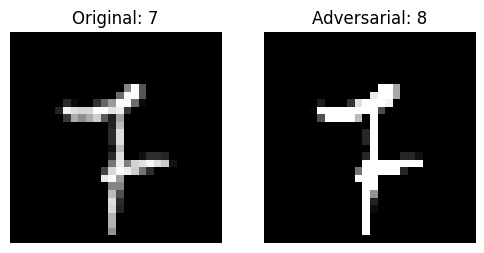

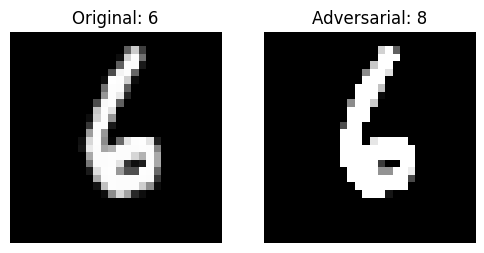

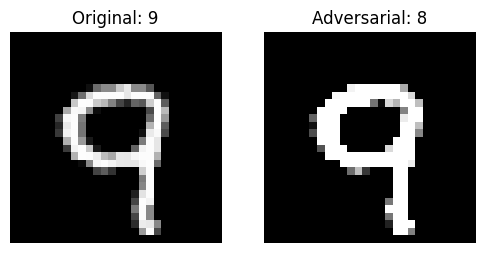

Success Rate: 0.9500


In [14]:
# Define the PGDL2 attack
attack_pgdl2 = torchattacks.PGDL2(model)

# Function to convert a tensor to a numpy image (adjusted for grayscale images)
def tensor_to_image(tensor):
    image = tensor.cpu().numpy()
    image = image * 0.3081 + 0.1307  # De-normalize the image
    if image.shape[0] == 1:
        image = image.squeeze(0)
    return image

# Function to display original and adversarial images side by side
def show_images_side_by_side(original_image, adversarial_image, original_label, adversarial_label, classes):
    original_image = tensor_to_image(original_image)
    adversarial_image = tensor_to_image(adversarial_image)
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))

    # Original image
    axs[0].imshow(original_image, cmap='gray')
    axs[0].axis('off')
    axs[0].set_title(f"Original: {classes[original_label]}")

    # Adversarial image
    axs[1].imshow(adversarial_image, cmap='gray')
    axs[1].axis('off')
    axs[1].set_title(f"Adversarial: {classes[adversarial_label]}")

    plt.show()

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = 100  # Number of samples to test

for _ in range(total_samples):
    index_pgdl2 = np.random.randint(0, len(test_loader.dataset))
    original_image_pgdl2, original_label_pgdl2 = test_loader.dataset[index_pgdl2]

    original_label_tensor_pgdl2 = torch.tensor(original_label_pgdl2)
    original_image_pgdl2 = original_image_pgdl2.unsqueeze(0).to(device)
    original_label_tensor_pgdl2 = original_label_tensor_pgdl2.unsqueeze(0).to(device)

    adv_images_pgdl2 = attack_pgdl2(original_image_pgdl2, original_label_tensor_pgdl2)

    original_prediction_pgdl2 = torch.argmax(model(original_image_pgdl2))
    adversarial_prediction_pgdl2 = torch.argmax(model(adv_images_pgdl2))

    if original_prediction_pgdl2 != adversarial_prediction_pgdl2:
        successful_attacks += 1

    if _ < 5:
        show_images_side_by_side(
            original_image_pgdl2.cpu().squeeze(),
            adv_images_pgdl2.cpu().squeeze(),
            original_prediction_pgdl2.item(),
            adversarial_prediction_pgdl2.item(),
            classes
        )

# Calculate the success rate
success_rate = successful_attacks / total_samples
print(f"Success Rate: {success_rate:.4f}")


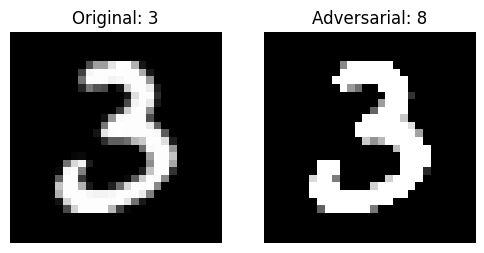

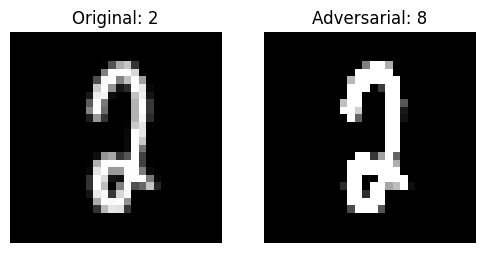

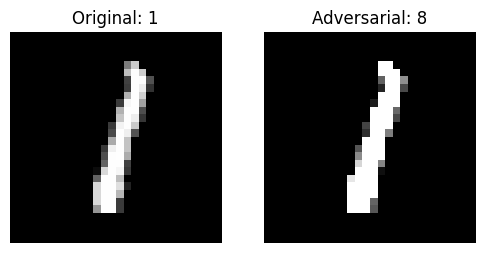

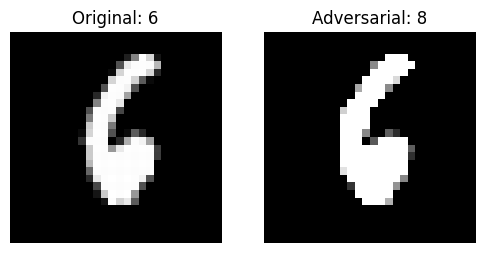

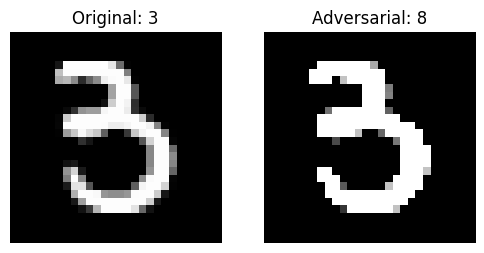

Success Rate: 0.9000


In [15]:
# Define the PGDRSL2 attack
attack_pgdrsl2 = torchattacks.PGDRSL2(model)

# Function to convert a tensor to a numpy image (adjusted for grayscale images)
def tensor_to_image(tensor):
    image = tensor.cpu().numpy()
    image = image * 0.3081 + 0.1307  # De-normalize the image
    if image.shape[0] == 1:
        image = image.squeeze(0)
    return image

# Function to display original and adversarial images side by side
def show_images_side_by_side(original_image, adversarial_image, original_label, adversarial_label, classes):
    original_image = tensor_to_image(original_image)
    adversarial_image = tensor_to_image(adversarial_image)
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))

    # Original image
    axs[0].imshow(original_image, cmap='gray')
    axs[0].axis('off')
    axs[0].set_title(f"Original: {classes[original_label]}")

    # Adversarial image
    axs[1].imshow(adversarial_image, cmap='gray')
    axs[1].axis('off')
    axs[1].set_title(f"Adversarial: {classes[adversarial_label]}")

    plt.show()

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = 100  # Number of samples to test

for _ in range(total_samples):
    index_pgdrsl2 = np.random.randint(0, len(test_loader.dataset))
    original_image_pgdrsl2, original_label_pgdrsl2 = test_loader.dataset[index_pgdrsl2]

    original_label_tensor_pgdrsl2 = torch.tensor(original_label_pgdrsl2)
    original_image_pgdrsl2 = original_image_pgdrsl2.unsqueeze(0).to(device)
    original_label_tensor_pgdrsl2 = original_label_tensor_pgdrsl2.unsqueeze(0).to(device)

    adv_images_pgdrsl2 = attack_pgdrsl2(original_image_pgdrsl2, original_label_tensor_pgdrsl2)

    original_prediction_pgdrsl2 = torch.argmax(model(original_image_pgdrsl2))
    adversarial_prediction_pgdrsl2 = torch.argmax(model(adv_images_pgdrsl2))

    if original_prediction_pgdrsl2 != adversarial_prediction_pgdrsl2:
        successful_attacks += 1

    if _ < 5:
        show_images_side_by_side(
            original_image_pgdrsl2.cpu().squeeze(),
            adv_images_pgdrsl2.cpu().squeeze(),
            original_prediction_pgdrsl2.item(),
            adversarial_prediction_pgdrsl2.item(),
            classes
        )

# Calculate the success rate
success_rate = successful_attacks / total_samples
print(f"Success Rate: {success_rate:.4f}")


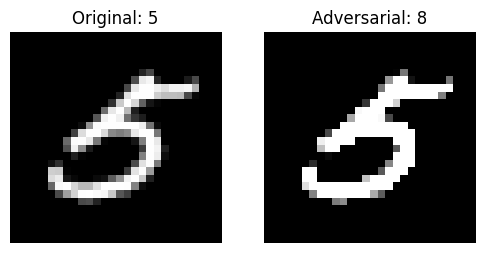

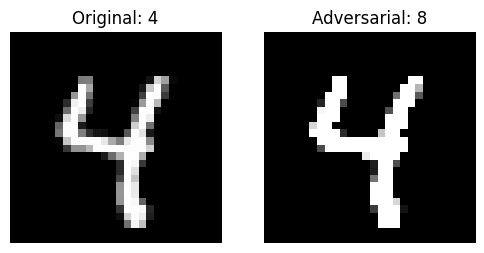

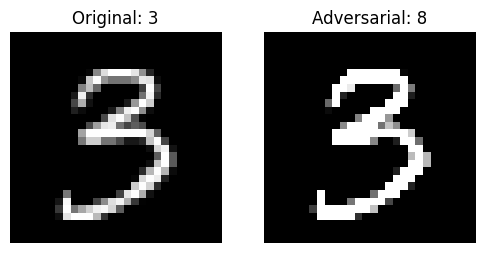

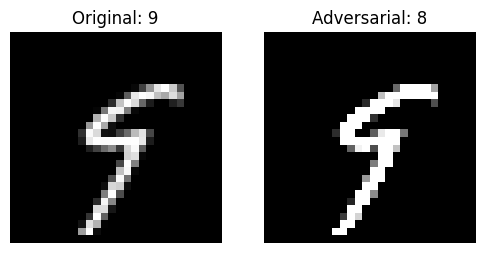

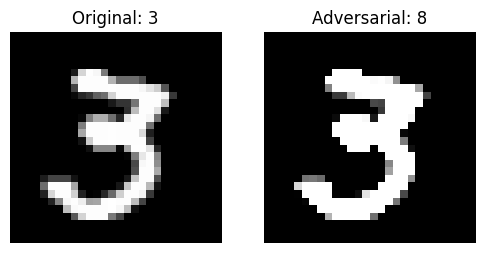

Success Rate: 0.9500


In [16]:
# Define the DeepFool attack
attack_deepfool = torchattacks.DeepFool(model)

# Function to convert a tensor to a numpy image (adjusted for grayscale images)
def tensor_to_image(tensor):
    image = tensor.cpu().numpy()
    image = image * 0.3081 + 0.1307  # De-normalize the image
    if image.shape[0] == 1:
        image = image.squeeze(0)
    return image

# Function to display original and adversarial images side by side
def show_images_side_by_side(original_image, adversarial_image, original_label, adversarial_label, classes):
    original_image = tensor_to_image(original_image)
    adversarial_image = tensor_to_image(adversarial_image)
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))

    # Original image
    axs[0].imshow(original_image, cmap='gray')
    axs[0].axis('off')
    axs[0].set_title(f"Original: {classes[original_label]}")

    # Adversarial image
    axs[1].imshow(adversarial_image, cmap='gray')
    axs[1].axis('off')
    axs[1].set_title(f"Adversarial: {classes[adversarial_label]}")

    plt.show()

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = 100  # Number of samples to test

for _ in range(total_samples):
    index_deepfool = np.random.randint(0, len(test_loader.dataset))
    original_image_deepfool, original_label_deepfool = test_loader.dataset[index_deepfool]

    original_label_tensor_deepfool = torch.tensor(original_label_deepfool)
    original_image_deepfool = original_image_deepfool.unsqueeze(0).to(device)
    original_label_tensor_deepfool = original_label_tensor_deepfool.unsqueeze(0).to(device)

    adv_images_deepfool = attack_deepfool(original_image_deepfool, original_label_tensor_deepfool)

    original_prediction_deepfool = torch.argmax(model(original_image_deepfool))
    adversarial_prediction_deepfool = torch.argmax(model(adv_images_deepfool))

    if original_prediction_deepfool != adversarial_prediction_deepfool:
        successful_attacks += 1

    if _ < 5:
        show_images_side_by_side(
            original_image_deepfool.cpu().squeeze(),
            adv_images_deepfool.cpu().squeeze(),
            original_prediction_deepfool.item(),
            adversarial_prediction_deepfool.item(),
            classes
        )

# Calculate the success rate
success_rate = successful_attacks / total_samples
print(f"Success Rate: {success_rate:.4f}")


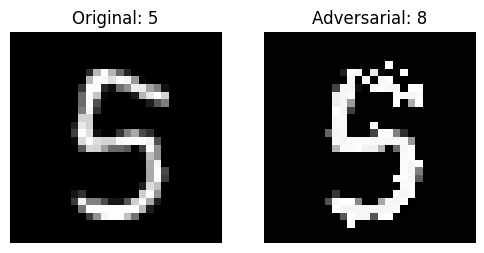

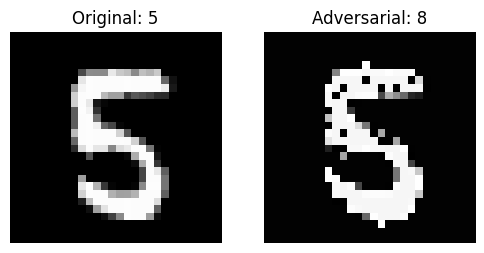

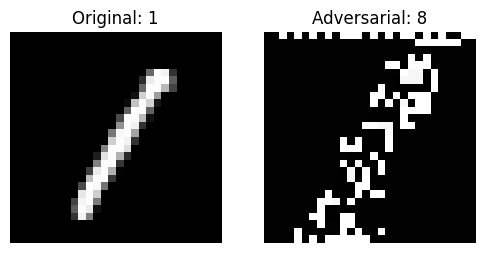

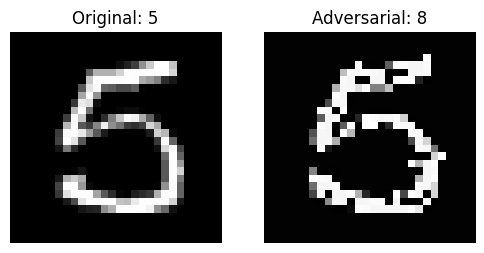

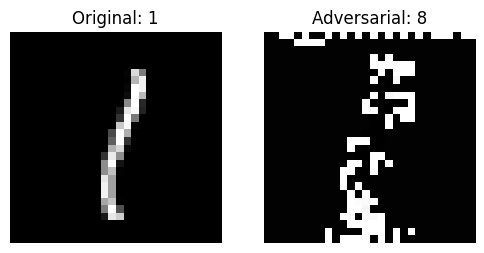

Success Rate: 0.9600


In [17]:
# Define the SparseFool attack
attack_sparsefool = torchattacks.SparseFool(model)

# Function to convert a tensor to a numpy image (adjusted for grayscale images)
def tensor_to_image(tensor):
    image = tensor.cpu().numpy()
    image = image * 0.3081 + 0.1307  # De-normalize the image
    if image.shape[0] == 1:
        image = image.squeeze(0)
    return image

# Function to display original and adversarial images side by side
def show_images_side_by_side(original_image, adversarial_image, original_label, adversarial_label, classes):
    original_image = tensor_to_image(original_image)
    adversarial_image = tensor_to_image(adversarial_image)
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))

    # Original image
    axs[0].imshow(original_image, cmap='gray')
    axs[0].axis('off')
    axs[0].set_title(f"Original: {classes[original_label]}")

    # Adversarial image
    axs[1].imshow(adversarial_image, cmap='gray')
    axs[1].axis('off')
    axs[1].set_title(f"Adversarial: {classes[adversarial_label]}")

    plt.show()

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = 100  # Number of samples to test

for _ in range(total_samples):
    index_sparsefool = np.random.randint(0, len(test_loader.dataset))
    original_image_sparsefool, original_label_sparsefool = test_loader.dataset[index_sparsefool]

    original_label_tensor_sparsefool = torch.tensor(original_label_sparsefool)
    original_image_sparsefool = original_image_sparsefool.unsqueeze(0).to(device)
    original_label_tensor_sparsefool = original_label_tensor_sparsefool.unsqueeze(0).to(device)

    adv_images_sparsefool = attack_sparsefool(original_image_sparsefool, original_label_tensor_sparsefool)

    original_prediction_sparsefool = torch.argmax(model(original_image_sparsefool))
    adversarial_prediction_sparsefool = torch.argmax(model(adv_images_sparsefool))

    if original_prediction_sparsefool != adversarial_prediction_sparsefool:
        successful_attacks += 1

    if _ < 5:
        show_images_side_by_side(
            original_image_sparsefool.cpu().squeeze(),
            adv_images_sparsefool.cpu().squeeze(),
            original_prediction_sparsefool.item(),
            adversarial_prediction_sparsefool.item(),
            classes
        )

# Calculate the success rate
success_rate = successful_attacks / total_samples
print(f"Success Rate: {success_rate:.4f}")


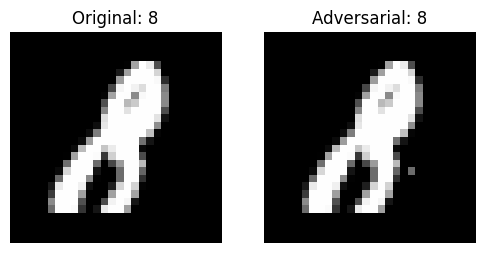

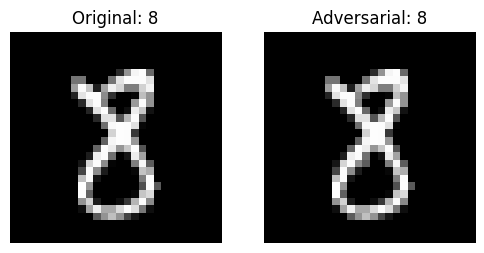

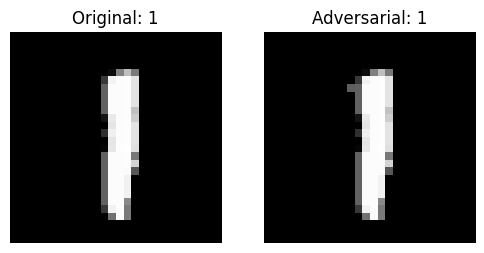

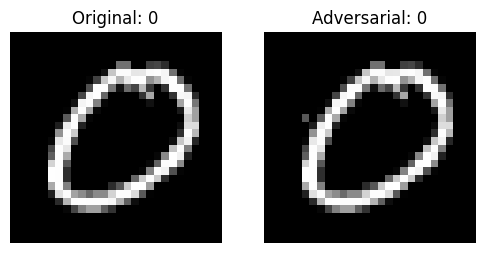

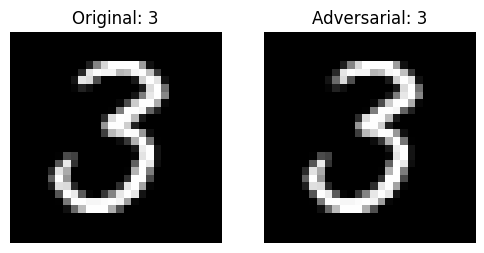

Success Rate: 0.0100


In [18]:
# Define the OnePixel attack
attack_onepixel = torchattacks.OnePixel(model)

# Function to convert a tensor to a numpy image (adjusted for grayscale images)
def tensor_to_image(tensor):
    image = tensor.cpu().numpy()
    image = image * 0.3081 + 0.1307  # De-normalize the image
    if image.shape[0] == 1:
        image = image.squeeze(0)
    return image

# Function to display original and adversarial images side by side
def show_images_side_by_side(original_image, adversarial_image, original_label, adversarial_label, classes):
    original_image = tensor_to_image(original_image)
    adversarial_image = tensor_to_image(adversarial_image)
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))

    # Original image
    axs[0].imshow(original_image, cmap='gray')
    axs[0].axis('off')
    axs[0].set_title(f"Original: {classes[original_label]}")

    # Adversarial image
    axs[1].imshow(adversarial_image, cmap='gray')
    axs[1].axis('off')
    axs[1].set_title(f"Adversarial: {classes[adversarial_label]}")

    plt.show()

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = 100  # Number of samples to test

for _ in range(total_samples):
    index_onepixel = np.random.randint(0, len(test_loader.dataset))
    original_image_onepixel, original_label_onepixel = test_loader.dataset[index_onepixel]

    original_label_tensor_onepixel = torch.tensor(original_label_onepixel)
    original_image_onepixel = original_image_onepixel.unsqueeze(0).to(device)
    original_label_tensor_onepixel = original_label_tensor_onepixel.unsqueeze(0).to(device)

    adv_images_onepixel = attack_onepixel(original_image_onepixel, original_label_tensor_onepixel)

    original_prediction_onepixel = torch.argmax(model(original_image_onepixel))
    adversarial_prediction_onepixel = torch.argmax(model(adv_images_onepixel))

    if original_prediction_onepixel != adversarial_prediction_onepixel:
        successful_attacks += 1

    if _ < 5:
        show_images_side_by_side(
            original_image_onepixel.cpu().squeeze(),
            adv_images_onepixel.cpu().squeeze(),
            original_prediction_onepixel.item(),
            adversarial_prediction_onepixel.item(),
            classes
        )

# Calculate the success rate
success_rate = successful_attacks / total_samples
print(f"Success Rate: {success_rate:.4f}")
